In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


IMPORTING ALL THE LIBRARIES REQUIRED


Downloading and preprocessing the dataset

In [ ]:
import pandas as pd
import numpy as np

import os
import sys
import soundfile
import os, glob, pickle

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
ravedess = '/content/drive/MyDrive/ds_dataset'

In [ ]:
# Set the directory path where the audio files are stored
dir_path = ravedess
# Initialize an empty list to store the audio data
r_audio_data = []

# Loop through all the audio files in the directory
for file in os.listdir(dir_path):
    # Load the audio file using librosa
    audio, sr = librosa.load(os.path.join(dir_path, file))
    
    # Append the audio data to the list
    r_audio_data.append(audio)


paths = []
labels = []
for dirname, _, filenames in os.walk(ravedess):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 1440:
         break
# print(labels)
print('Dataset is Loaded')

df= pd.DataFrame()
df['speech']= paths
df['emotion']= labels

df['labels']=df['emotion'].apply(lambda x: x[7])
df
df['labels']=df['labels'].map({'1':'Neutral','2':'Neutral','3':'Happy','4':'Sad','5':'Angry','6':'Fearful','7':'Disgust','8':'Surprised'})







Dataset is Loaded


In [ ]:
df.drop('emotion',axis = 1, inplace = True)

In [ ]:
df.drop(df[df['labels'] == 'Disgust'].index, inplace=True)

In [ ]:
print(df['labels'].value_counts())

Neutral      288
Happy        192
Sad          192
Angry        192
Fearful      192
Surprised    192
Name: labels, dtype: int64


FEATURE ENGINEERING

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

In [ ]:
path = np.array(df.speech)[1]
data, sample_rate = librosa.load(path)


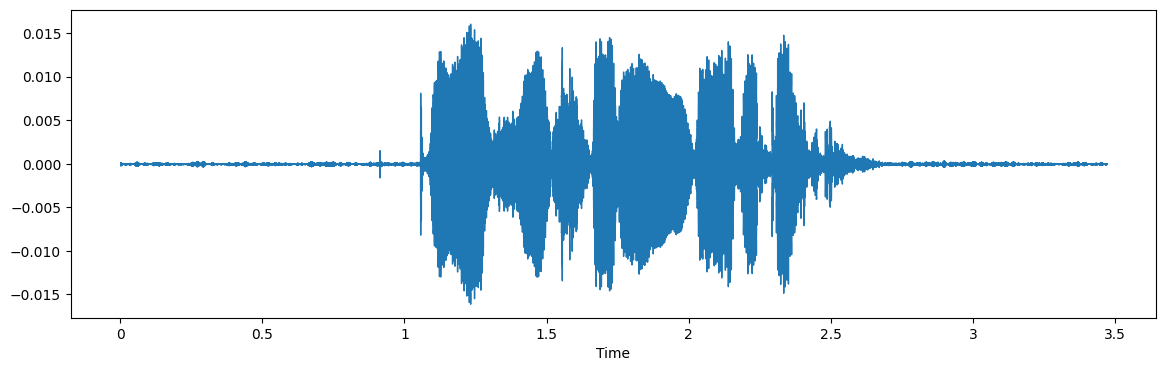

In [ ]:

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

NOISE INJECTION

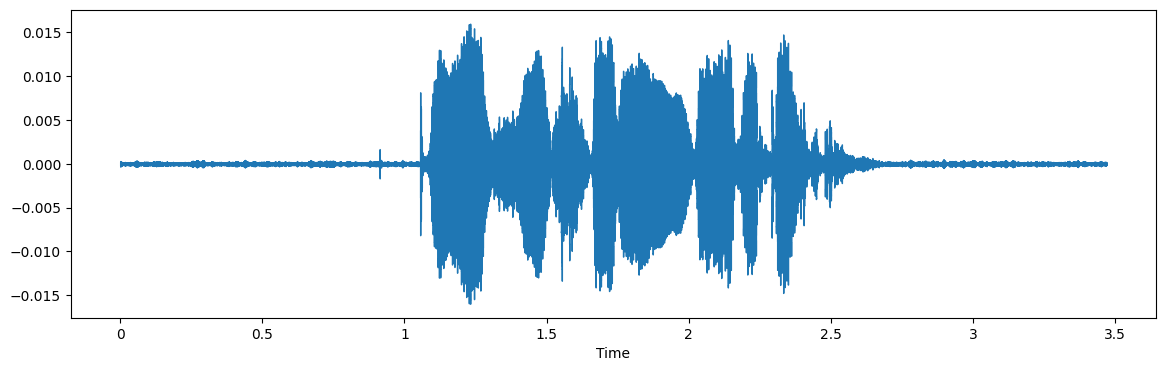

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

STRECTCHING- 

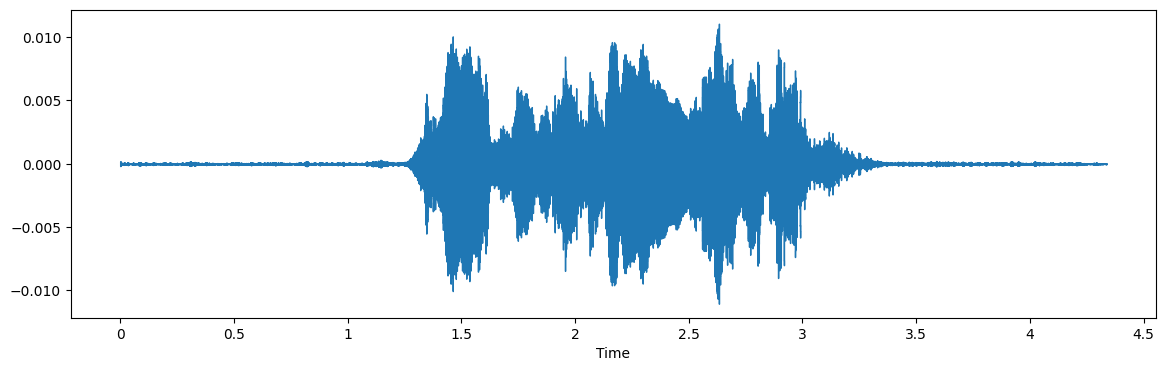

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

SHIFTING

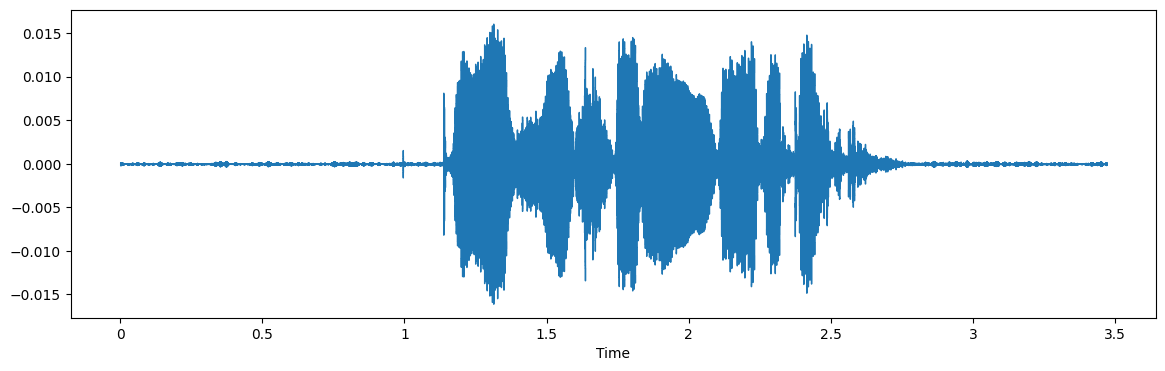

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Funtions to extract different features.

In [ ]:
def extract_mfcc(filename, max_length=100):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=15,n_fft=2048, hop_length=512).T, axis=0)
    return mfcc

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [ ]:
X_mfcc = np.array(X_mfcc.tolist())
print(X_mfcc.shape)  

(1248, 15)


In [ ]:
def extract_zcr(filename):
  y,sr = librosa.load(filename, duration = 3, offset = 0.5)
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)
  return zcr


In [ ]:
X_zcr = df['speech'].apply(lambda x: extract_zcr(x))

In [ ]:
X_zcr = np.array(X_zcr.tolist())
print(X_zcr.shape) 

(1248, 1)


In [ ]:
def extract_rms(filename):
  y,sr= librosa.load(filename, duration = 3,offset = 0.5)
  rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
  return rms

In [ ]:
X_rms = df['speech'].apply(lambda x: extract_rms(x))

In [ ]:
X_rms = np.array(X_rms.tolist())
print(X_rms.shape)  

(1248, 1)


In [ ]:
def extract_mell(filename):
  y,sr = librosa.load(filename , duration= 3, offset =0.5)
  mel = np.mean(librosa.feature.melspectrogram(y= y , sr=sr).T, axis=0)
  return mel

In [ ]:
X_mel = df['speech'].apply(lambda x: extract_rms(x))

In [ ]:
X_mel = np.array(X_mel.tolist())
print(X_mel.shape)  

(1248, 1)


In [ ]:
new_df = pd.DataFrame(X_mfcc)
new_df.head()
new_df['zcr']= X_zcr
new_df['rms'] = X_rms
new_df['mel'] = X_mel
new_df['labels']=df.labels
new_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,zcr,rms,mel,labels
0,-479.763336,51.792194,-27.373737,12.413802,2.507613,-15.138287,-4.111307,-16.546436,-5.805637,-7.830743,-12.044786,-4.939506,-7.853512,-2.655849,-4.742521,0.161997,0.014533,0.014533,Happy
1,-692.345154,73.853600,11.183147,22.484844,9.663150,3.359681,3.641027,-11.183654,-2.138980,-3.112401,0.355251,-7.436627,1.151342,-0.216681,-2.776512,0.150108,0.002049,0.002049,Neutral
2,-673.333984,74.062248,10.070873,19.803295,4.172618,2.558521,6.057234,-9.015502,-2.326800,-3.837869,-1.576903,-10.809388,-2.610172,-4.335229,-1.162542,0.163612,0.001836,0.001836,Neutral
3,-627.019836,65.743149,-1.984382,19.168814,8.411998,-4.089351,-0.652489,-10.962898,-0.953377,-3.926661,-3.228476,-4.353993,-3.775071,1.037004,-2.427280,0.173790,0.004441,0.004441,Happy
4,-611.721741,69.032394,-7.955007,16.027355,8.655052,-7.593324,-5.145872,-20.467379,-4.566681,1.402165,-8.784488,-6.514793,-3.174536,-1.078765,-1.315418,0.136591,0.004072,0.004072,Sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,-673.484985,78.985306,9.472679,20.932680,6.785698,0.310028,4.021769,-11.046672,-2.580672,-3.761756,0.383701,-7.616463,-0.660424,-2.614213,-1.146237,0.151213,0.002056,0.002056,Neutral
1244,-607.591675,61.154602,-11.845318,22.319328,4.487621,-5.201904,-0.349164,-8.826373,-0.999149,-2.382788,-1.278017,-5.204308,-1.580768,-0.318945,-1.277201,0.142459,0.004390,0.004390,Neutral
1245,-677.565613,69.741425,15.144119,19.460772,5.905962,6.222984,5.044274,-7.407664,-4.059206,-2.730590,-1.426167,-8.839830,-1.956763,-2.150124,-4.591712,0.140062,0.001906,0.001906,Neutral
1246,-694.996521,76.103989,11.912189,17.987270,10.349315,4.824117,-1.749052,-12.369832,-4.407050,0.796404,2.435637,-9.847482,1.112318,0.414144,-0.028678,0.143825,0.001727,0.001727,Neutral


In [ ]:
X_final =new_df.iloc[: ,:-1].values
X_final.shape

(1248, 18)

In [ ]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,zcr,rms,mel,labels
0,-479.763336,51.792194,-27.373737,12.413802,2.507613,-15.138287,-4.111307,-16.546436,-5.805637,-7.830743,-12.044786,-4.939506,-7.853512,-2.655849,-4.742521,0.161997,0.014533,0.014533,Happy
1,-692.345154,73.853600,11.183147,22.484844,9.663150,3.359681,3.641027,-11.183654,-2.138980,-3.112401,0.355251,-7.436627,1.151342,-0.216681,-2.776512,0.150108,0.002049,0.002049,Neutral
2,-673.333984,74.062248,10.070873,19.803295,4.172618,2.558521,6.057234,-9.015502,-2.326800,-3.837869,-1.576903,-10.809388,-2.610172,-4.335229,-1.162542,0.163612,0.001836,0.001836,Neutral
3,-627.019836,65.743149,-1.984382,19.168814,8.411998,-4.089351,-0.652489,-10.962898,-0.953377,-3.926661,-3.228476,-4.353993,-3.775071,1.037004,-2.427280,0.173790,0.004441,0.004441,Happy
4,-611.721741,69.032394,-7.955007,16.027355,8.655052,-7.593324,-5.145872,-20.467379,-4.566681,1.402165,-8.784488,-6.514793,-3.174536,-1.078765,-1.315418,0.136591,0.004072,0.004072,Sad


CORRELATION ANALYSIS

<ipython-input-24-4776be1d3aae>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = new_df.corr()


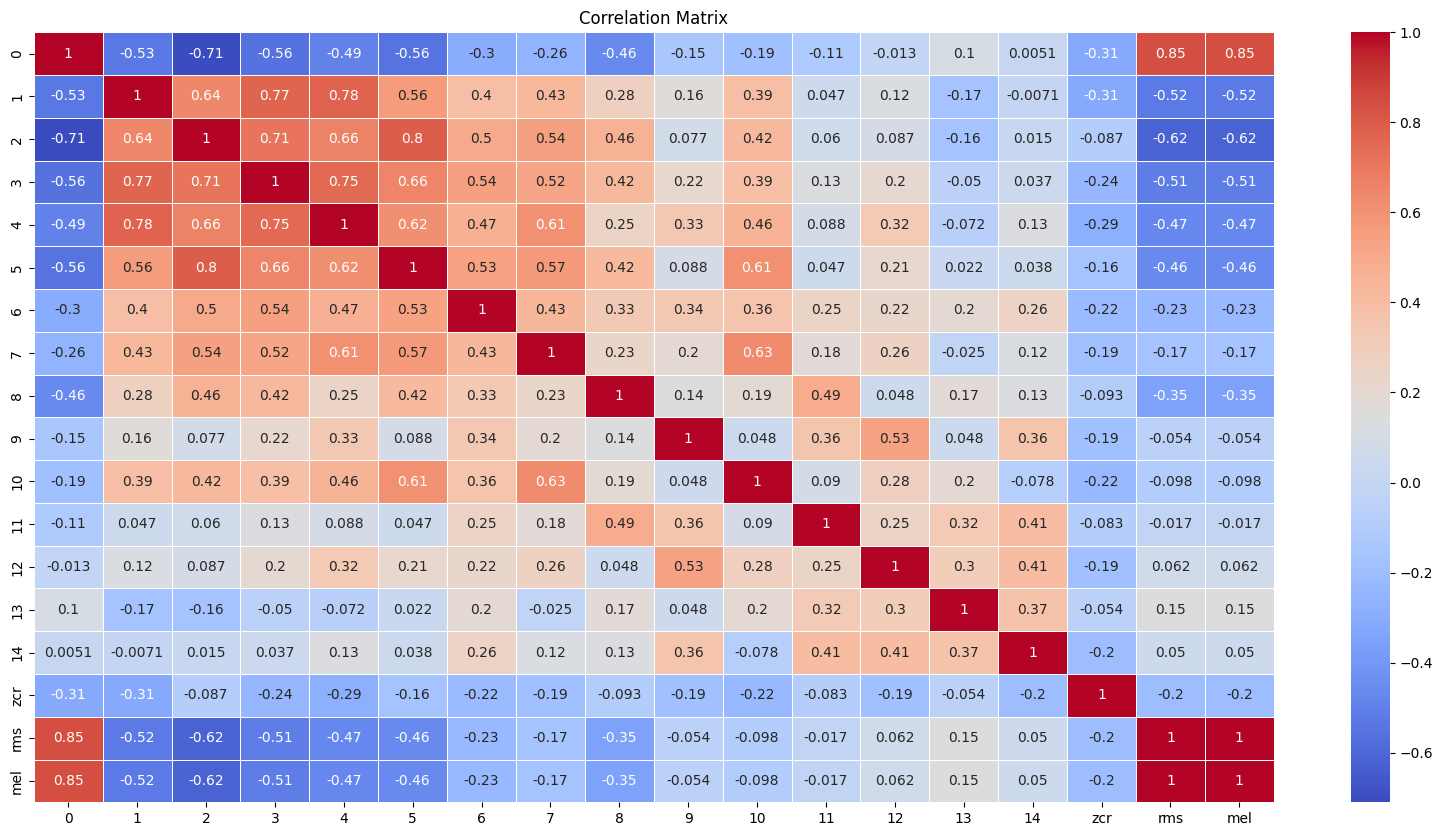

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named df and contains the 18 features as columns

# Compute the correlation matrix
correlation_matrix = new_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

COVARIANCE ANALYSIS

<ipython-input-25-2de93309aaa3>:1: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  covar_matrix = new_df.cov()


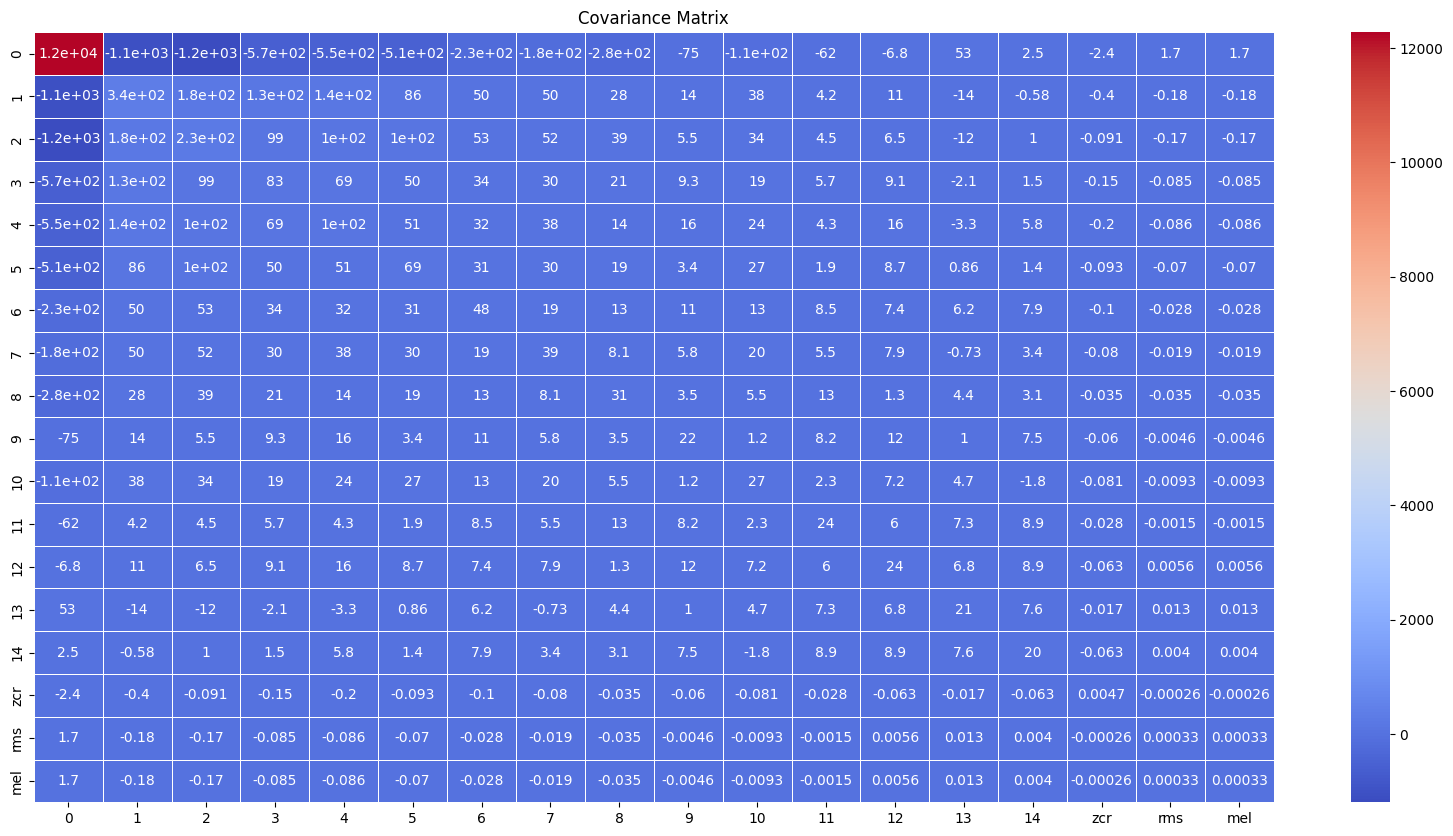

In [ ]:
covar_matrix = new_df.cov()
# print(covar_matrix)
plt.figure(figsize=(20, 10))
sns.heatmap(covar_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Covariance Matrix")
plt.show()

In [ ]:

col = {}
for i in range(15):
  col[i] = f'mfcc_{i+1}'
new_df.rename(columns= col , inplace=True)
new_df


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,zcr,rms,mel,labels
0,-479.763336,51.792194,-27.373737,12.413802,2.507613,-15.138287,-4.111307,-16.546436,-5.805637,-7.830743,-12.044786,-4.939506,-7.853512,-2.655849,-4.742521,0.161997,0.014533,0.014533,Happy
1,-692.345154,73.853600,11.183147,22.484844,9.663150,3.359681,3.641027,-11.183654,-2.138980,-3.112401,0.355251,-7.436627,1.151342,-0.216681,-2.776512,0.150108,0.002049,0.002049,Neutral
2,-673.333984,74.062248,10.070873,19.803295,4.172618,2.558521,6.057234,-9.015502,-2.326800,-3.837869,-1.576903,-10.809388,-2.610172,-4.335229,-1.162542,0.163612,0.001836,0.001836,Neutral
3,-627.019836,65.743149,-1.984382,19.168814,8.411998,-4.089351,-0.652489,-10.962898,-0.953377,-3.926661,-3.228476,-4.353993,-3.775071,1.037004,-2.427280,0.173790,0.004441,0.004441,Happy
4,-611.721741,69.032394,-7.955007,16.027355,8.655052,-7.593324,-5.145872,-20.467379,-4.566681,1.402165,-8.784488,-6.514793,-3.174536,-1.078765,-1.315418,0.136591,0.004072,0.004072,Sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,-673.484985,78.985306,9.472679,20.932680,6.785698,0.310028,4.021769,-11.046672,-2.580672,-3.761756,0.383701,-7.616463,-0.660424,-2.614213,-1.146237,0.151213,0.002056,0.002056,Neutral
1244,-607.591675,61.154602,-11.845318,22.319328,4.487621,-5.201904,-0.349164,-8.826373,-0.999149,-2.382788,-1.278017,-5.204308,-1.580768,-0.318945,-1.277201,0.142459,0.004390,0.004390,Neutral
1245,-677.565613,69.741425,15.144119,19.460772,5.905962,6.222984,5.044274,-7.407664,-4.059206,-2.730590,-1.426167,-8.839830,-1.956763,-2.150124,-4.591712,0.140062,0.001906,0.001906,Neutral
1246,-694.996521,76.103989,11.912189,17.987270,10.349315,4.824117,-1.749052,-12.369832,-4.407050,0.796404,2.435637,-9.847482,1.112318,0.414144,-0.028678,0.143825,0.001727,0.001727,Neutral


In [ ]:
cols= new_df.keys()
type(cols)
cols = list(cols)
req_cols = cols[:15]
req_cols

['mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15']

DIMENSIONALITY REDUCTION

In [ ]:
# as the correlation of mel and rms is one will club them into one
rms_mel= ['rms','mel']

In [ ]:
from sklearn.decomposition import PCA
num_components = 1
pca = PCA(n_components= num_components)
sel_df = new_df[req_cols]
sel_df2 = new_df[rms_mel]
pca_result = pca.fit_transform(sel_df)
pca_result_2 = pca.fit_transform(sel_df2)


pc_columns = [f'PC{i+1}' for i in range(num_components)]  
df_pca = pd.DataFrame(data=pca_result, columns=pc_columns)
df_pca2 = pd.DataFrame(data = pca_result_2 , columns = ['rms_mel'])
df_final = pd.concat([new_df, df_pca, df_pca2], axis=1)
df_f = pd.concat([ df_pca, df_pca2], axis=1)


# print(df_final.head())
print(df_f.head())


          PC1   rms_mel
0   68.754402  0.000592
1 -148.938858 -0.017063
2 -129.718719 -0.017364
3  -81.802635 -0.013680
4  -65.790581 -0.014201


In [ ]:
df_f['zcr'] = new_df['zcr']

CORRELATION  AND COVARIANCE ANALYSIS AFTER DIMENSIONALITY REDUCTION

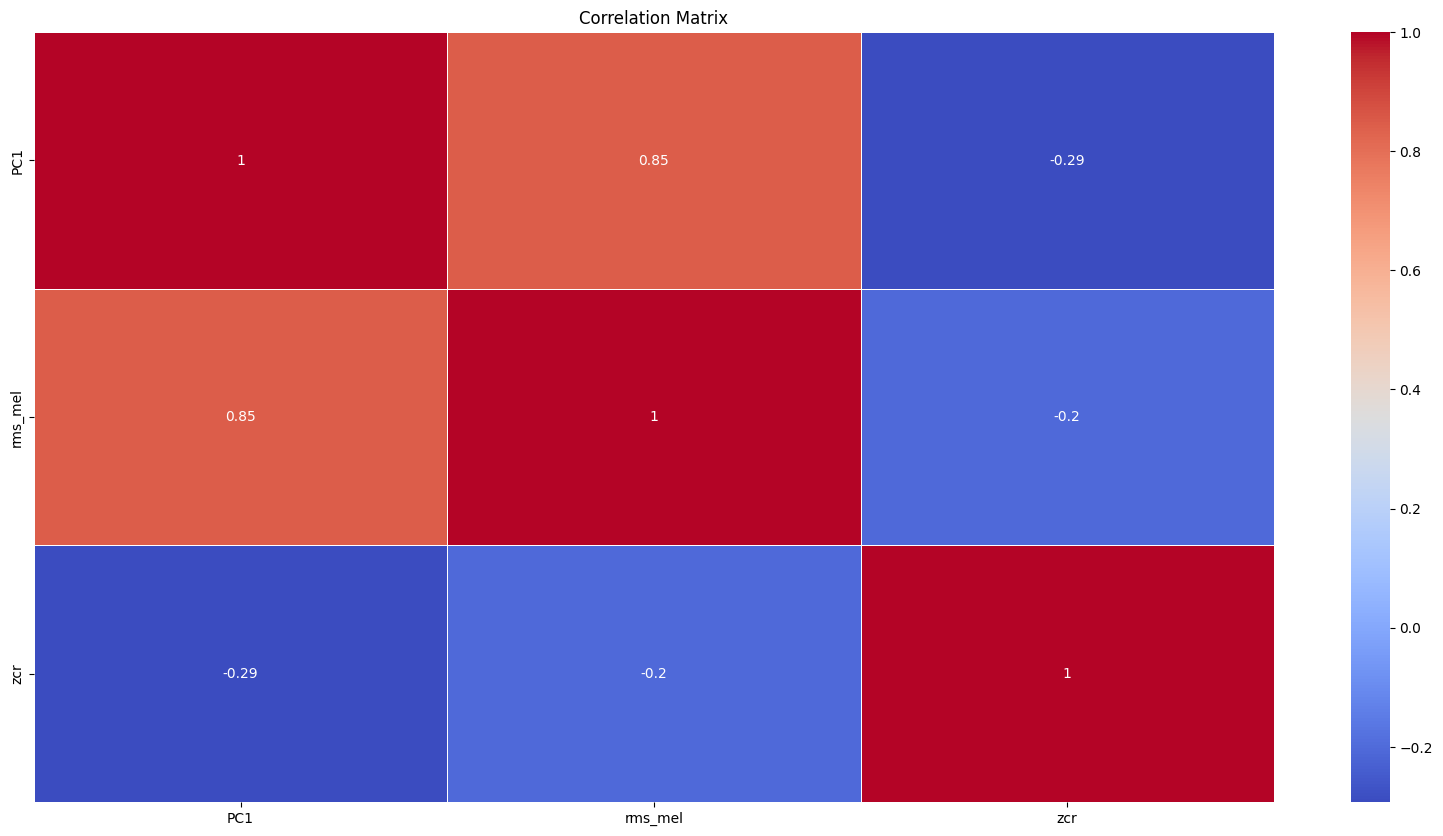

In [ ]:
correlation_matrix = df_f.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

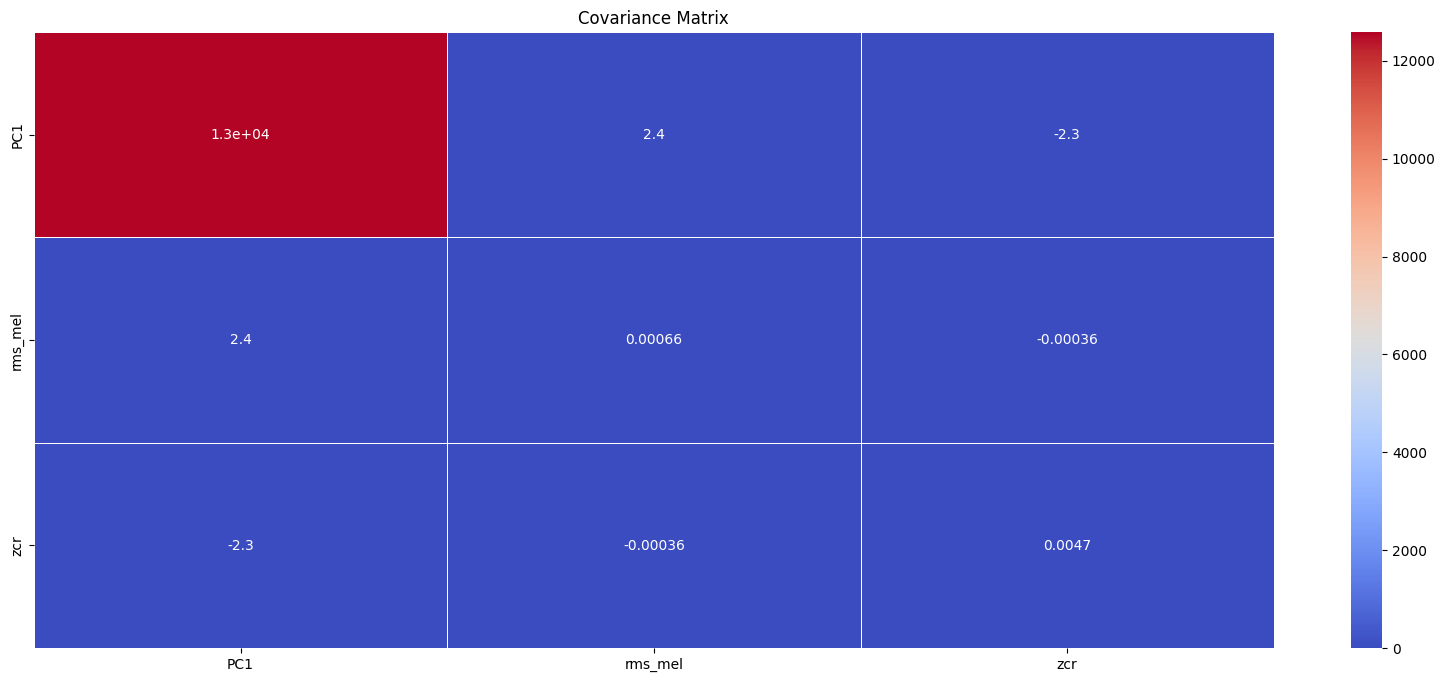

In [ ]:
covar_matrix = df_f.cov()
# print(covar_matrix)
plt.figure(figsize=(20, 8))
sns.heatmap(covar_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Covariance Matrix")
plt.show()

In [ ]:
red_df = df_final

In [ ]:
red_df.head(2)

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_12,mfcc_13,mfcc_14,mfcc_15,zcr,rms,mel,labels,PC1,rms_mel
0,-479.763336,51.792194,-27.373737,12.413802,2.507613,-15.138287,-4.111307,-16.546436,-5.805637,-7.830743,...,-4.939506,-7.853512,-2.655849,-4.742521,0.161997,0.014533,0.014533,Happy,68.754402,0.000592
1,-692.345154,73.853600,11.183147,22.484844,9.663150,3.359681,3.641027,-11.183654,-2.138980,-3.112401,...,-7.436627,1.151342,-0.216681,-2.776512,0.150108,0.002049,0.002049,Neutral,-148.938858,-0.017063


In [ ]:
red_df.head(2)

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_12,mfcc_13,mfcc_14,mfcc_15,zcr,rms,mel,labels,PC1,rms_mel
0,-479.763336,51.792194,-27.373737,12.413802,2.507613,-15.138287,-4.111307,-16.546436,-5.805637,-7.830743,...,-4.939506,-7.853512,-2.655849,-4.742521,0.161997,0.014533,0.014533,Happy,68.754402,0.000592
1,-692.345154,73.853600,11.183147,22.484844,9.663150,3.359681,3.641027,-11.183654,-2.138980,-3.112401,...,-7.436627,1.151342,-0.216681,-2.776512,0.150108,0.002049,0.002049,Neutral,-148.938858,-0.017063
